In [ ]:
# Processamento de Imagens SCC0251 - 2022.1
# Projeto Final

# Nomes: 
  # João Victor Sene Araújo  | nUSP: 11796382
  # Pedro Augusto Ribeiro Gomes | nUSP: 11819125

# Algoritmo para Restauração de Imagens

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Restored PSF')

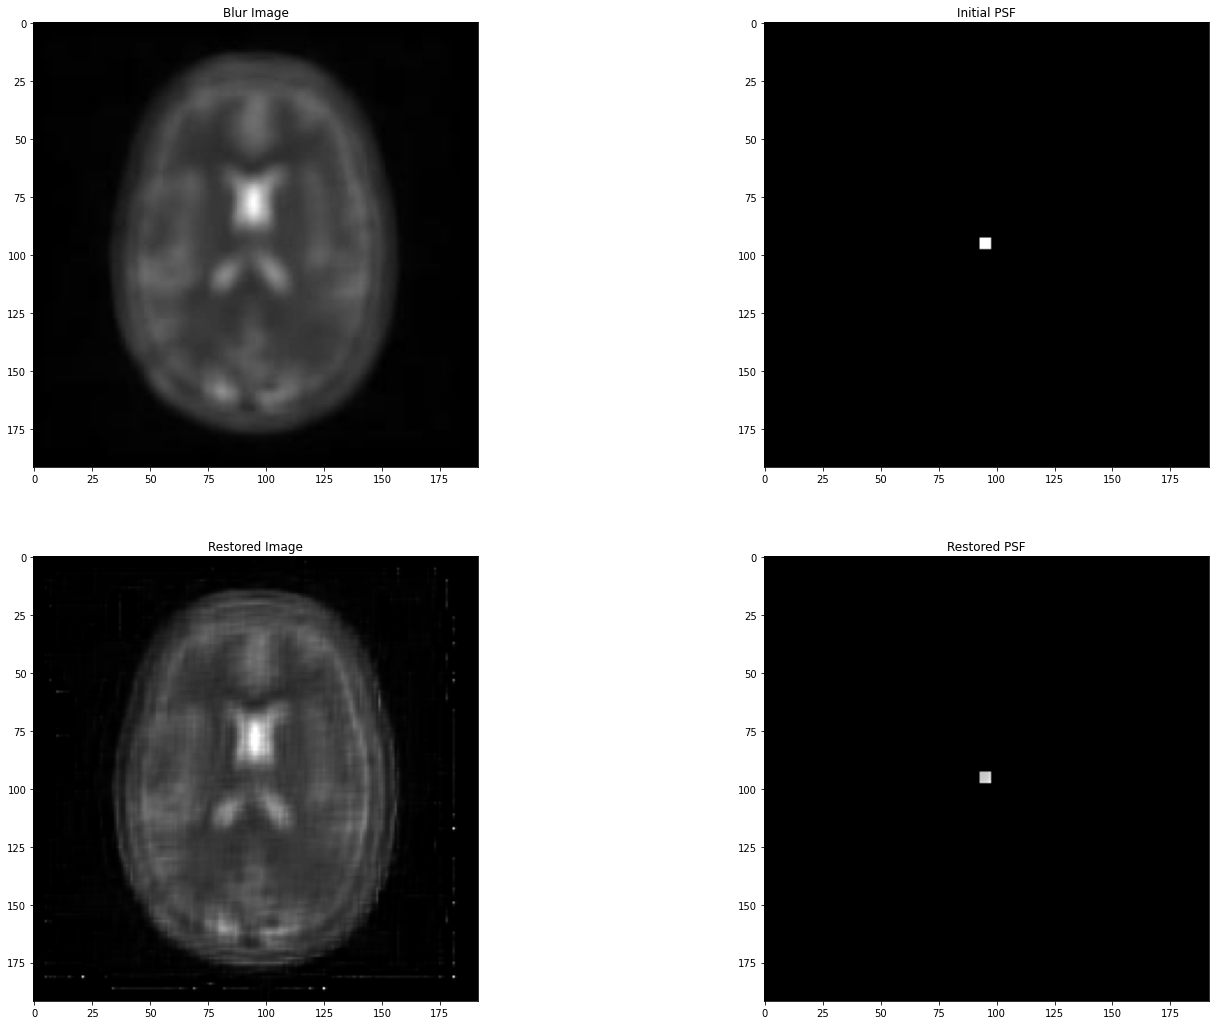

In [ ]:
def fftConvolve(img,psf):
  """
    Realiza uma convolução no domínio de frequência entre uma imagem e uma psf(point spread function)

      Parâmetros:
        img = imagem que irá passar pelo filtro
        psf = point spread function associada ao borrão de movimento na imagem

      Retorno: 
        Resultado da convolução entre as duas matrizes
  """
  otf = np.fft.fft2(psf)

  F = np.fft.fft2(img)
  F = np.multiply(F,otf)

  return np.fft.fftshift(abs(np.fft.ifft2(F)))

def normalize(img):
  """
    Normaliza a imagem dada (coloca os valores dos pixels entre 0 e 255)

      Parâmetros:
        img = matriz da imagem que vai ser normalizada

      Retorno: 
        imagem normalizada
  """
  imgN = img.copy()
  imgN = (imgN - np.min(imgN[:])) / (np.max(imgN[:]) - np.min(imgN[:]))
  imgN = (imgN*255).astype(np.uint8)

  return imgN

def paddingKernel(img,kernel):
  """
    Aplica o padding em um filtro(kernel) referente ao tamanho da imagem dada

      Parâmetros:
        img = imagem de referência
        kernel = filtro a ser aplicado o padding

      Retorno: 
        Kernel com padding
  """
  padSize = int(img.shape[0]//2 - kernel.shape[0]//2)
  paddedArr = np.pad(kernel, (padSize-1, padSize-1), 'constant',constant_values=(0))
  gaussianFilterPad = np.zeros_like(img).astype(paddedArr.dtype)
  # copy the padded array to the gaussian filter_pad
  gaussianFilterPad[0:paddedArr.shape[0], 0:paddedArr.shape[1]] = paddedArr

  return gaussianFilterPad

def richardson_lucy_blind(img, psf, num_iter=50,debug=False):
  """
    Realiza o algorítimo de restauração Richardson-Lucy para uma determinada imagem
    utilizando uma psf como chute inicial para deconvoluir a imagem. Sendo u a imagem
    que será estimada, P a psf que também será estimada, d a imagem, P* a psf flipada
    e @ indicando convolução entre os termos:

    u_(t+1) = u_(t) * ( ( d / ( u_(t) @ P_(t) ) ) @ P_(t)* )

    P_(t+1) = P_(t) * ( ( d / ( u_(t+1) @ P_(t) ) ) @ u_(t+1)* )

    Esse processo será realizado 'maxIteration' vezes, com o objetivo de aprimorar
    a estimação (convergir para a imagem original)

      Parâmetros:
        img = imagem que irá passar pelo filtro
        psf = chute inicial para point spread function associada ao borrão de 
        movimento na imagem
        num_iter = número máximo de iteração realizadas pelo algoritmo

      Retorno: 
        Imagem estimada
  """
  u = np.full(img.shape, 0.1, dtype='float')
  
  eps = 1e-12

  for i in range(num_iter):
    psf_f = np.flip(psf)

    u_blur = fftConvolve(u,psf)+eps
    relative_blur = np.divide(img,u_blur)
    u *= fftConvolve(relative_blur,psf_f)

    u_f = np.flip(u)
    u_blur = fftConvolve(u, psf)+eps
    relative_blur = img / u_blur
    psf *= fftConvolve(relative_blur, u_f)

    if(debug):
      plt.figure(figsize=(16,9))
      plt.subplot(121)
      plt.imshow(u, cmap="gray", vmin=0, vmax=255); plt.title("image")
      plt.subplot(122)
      plt.imshow(normalize(psf), cmap="gray", vmin=0, vmax=255); plt.title("psf")

  return u,psf

imageName = "6 no.jpg"

maxIterations = 20

img_blur = imageio.imread(imageName)

psf_init = np.ones((5,5))/25
psf_init = paddingKernel(img_blur,psf_init)

img_restored,psf_restored = richardson_lucy_blind(img_blur, psf_init.copy(), num_iter=maxIterations)
img_restored = np.clip(img_restored.astype(int),0,255)
img_restored = normalize(img_restored)

plt.figure(figsize=(24,18))
plt.subplot(221)
plt.imshow(img_blur, cmap="gray", vmin=0, vmax=255); plt.title("Blur Image")
plt.subplot(222)
plt.imshow(normalize(psf_init), cmap="gray", vmin=0, vmax=255); plt.title("Initial PSF")
plt.subplot(223)
plt.imshow(img_restored, cmap="gray", vmin=0, vmax=255); plt.title("Restored Image")
plt.subplot(224)
plt.imshow(normalize(psf_restored), cmap="gray", vmin=0, vmax=255); plt.title("Restored PSF")
